In [1]:
import torch
import pandas as pd
import numpy as np 
from tqdm import tqdm
from matplotlib import pyplot as plt
# %matplotlib widget
from gym.spaces import Discrete, Box
import json
import requests
import random

In [2]:
from ray.rllib.utils.framework import try_import_torch
torch, nn = try_import_torch()

2024-01-17 10:26:20,241	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.6.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
d:\programdata\anaconda3\envs\binance\lib\site-packages\gymnasium\envs\registration.py:693: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
2024-01-17 10:26:21,086	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.6.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
import pymongo
from pymongo import MongoClient

In [4]:
client = pymongo.MongoClient("mongodb://localhost:27017")
db = client.Binance_test
collection = db.Binance_test

In [5]:
class NumpyArrayEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [6]:
obs_size = 3
a_size = 3
rnn_size = 64
frameskip = 5
fee_rate = 0.08

In [7]:
import zlib, json, base64
ZIPJSON_KEY = 'base64(zip(o))'
def json_zip(j):
    j = base64.b64encode(
            zlib.compress(
                json.dumps(j, cls=NumpyArrayEncoder).encode('utf-8')
            )
        )

    return j

def json_unzip(j, insist=True):
    try:
        j = zlib.decompress(base64.b64decode(j))
    except:
        raise RuntimeError("Could not decode/unzip the contents")

    try:
        j = json.loads(j)
    except:
        raise RuntimeError("Could interpret the unzipped contents")

    return j

In [8]:
class binance_worker:
    def __init__(self, worker_id = None):
        self.worker_id = worker_id
        self.last_action = 0
        self.ret = []
        self.last_reward = 0
        
        self.num_steps = random.randint(1,frameskip)
        
        self.state_h = np.zeros(rnn_size)
        self.state_c = np.zeros(rnn_size)
        
        self.price_stack = []
        
        self.pnl = 0.0
        self.fee = np.log(1 - (fee_rate / 100))
        
        self.gap = 0.0
        
        self.value = 0.0
        
        self.history_state = []
        self.history_action = []
        self.history_return = []
        self.history_fee = []
    def reset_state(self):
        self.state_h = np.zeros(rnn_size)
        self.state_c = np.zeros(rnn_size)
        self.last_action = 0
        

    def state_step(self, price_data, gap):
        self.price_stack.append(price_data)
        self.ret.append(gap)
        
        self.num_steps -= 1
        self.last_reward = 0.0

        self.history_state.append(price_data)
        self.history_action.append(self.last_action)
        self.history_return.append([0,1,-1][self.last_action]*gap)
        
        if self.num_steps == 0:
            price_mat = np.array(self.price_stack)
            self.price_stack.clear()
            
            log_price_ohlc = np.log(price_mat)
            
            state = np.zeros(obs_size)
            
#             state[0:6] = state2
            state[0] = log_price_ohlc[-1,-1]- log_price_ohlc[0,0]
            state[1] = np.max(log_price_ohlc) - np.min(log_price_ohlc)
            state[-1] = self.fee

            return state, self.state_h, self.state_c, self.last_action, self.last_reward, self.worker_id
        else:
            self.history_fee.append(0)
            return None

    def action_step(self, model_result):
        action, next_h, next_c, next_v = model_result
        self.num_steps = random.randint(frameskip-2, frameskip+2)
        
        gap = np.nansum(self.ret)
        self.ret.clear()
        
        self.last_reward = [0,1,-1][self.last_action]*gap
        self.pnl+=self.last_reward
        
        old_signal = [0,1,-1][self.last_action]
        new_signal = [0,1,-1][action]
        
        self.last_action = action
        self.state_h = next_h
        self.state_c = next_c

In [9]:
workers = []
for i in range(64):
    workers.append(binance_worker(i))

In [10]:
df = pd.DataFrame(list(collection.find(filter={"_id":
                                                                       {"$gte":
                                                                            0}
                                                                   },
                                                         sort=[("_id", 1)])
                                    )
                               )

In [11]:
def compute_worker(price_data, gap):
    global workers, pnl, last_signal, _temp
    batch_s = []
    batch_h = []
    batch_c = []
    batch_a = []
    batch_r = []
    batch_id = []
    for idx, w in enumerate(workers):
        state = w.state_step(price_data, gap)
        if state is not None:
            _s, _h, _c, _a, _r, _id = state 
            batch_s.append(_s)
            batch_h.append(_h)
            batch_c.append(_c)
            batch_a.append(_a)
            batch_r.append(_r)
            batch_id.append(_id)

    compressed_input = json_zip({
        "observation": batch_s,
        "state1": batch_h,
        "state2": batch_c,
        "prev_a": batch_a,
        "prev_r": batch_r
    })
    if len(batch_id) > 0:
        resp = requests.get("http://127.0.0.1:8000/model/", data=compressed_input)
        _x = json_unzip(resp.text)
        model_result = zip(batch_id, _x['action'], _x['state_h'], _x['state_c'], _x['value'])
        for idx, next_a, next_h, next_c, next_v in model_result:
            workers[idx].action_step((next_a, next_h, next_c, next_v))

requests.get("http://127.0.0.1:8000/model/", data=json_text).text

In [12]:
for idx, row in tqdm(df.iterrows()):
#     x = row[['btcusdt_FUTURES_Open','btcusdt_FUTURES_High','btcusdt_FUTURES_Low','btcusdt_FUTURES_Close']].values
    x = row[['btcusdt_FUTURES_Open',
                        'btcusdt_FUTURES_High',
                        'btcusdt_FUTURES_Low',
                        'btcusdt_FUTURES_Close',]].values
    g = np.nan_to_num(row['btcusdt_FUTURES_ret'])
    compute_worker(x,g)

43200it [24:10, 29.78it/s]


In [13]:
pro = []
act = []
for w in workers:
    pro.append(w.history_return)
    act.append(w.history_action)
pro = np.array(pro)
act = np.array(act)

In [14]:
position = np.array([0,1,-1])[act]
mean_position = np.mean(position,axis=0)

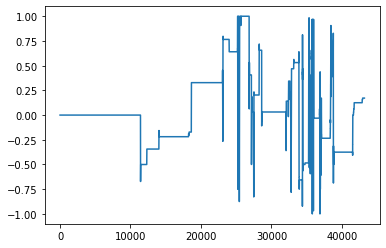

In [15]:
plt.plot(mean_position)
plt.show()

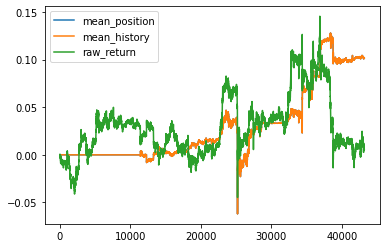

In [16]:
test = df['btcusdt_FUTURES_ret']*mean_position
plt.plot(test.cumsum(), label="mean_position")
plt.plot(np.mean(pro.cumsum(1), axis=0), label="mean_history")
plt.plot(df['btcusdt_FUTURES_ret'].cumsum(), label="raw_return")
plt.legend()
plt.show()

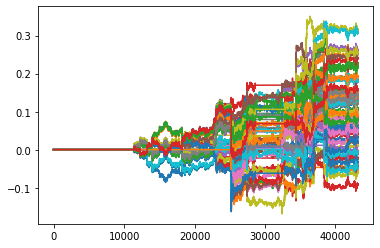

In [17]:
plt.plot(pro.cumsum(1).T)
plt.show()

In [18]:
fee_signal = np.concatenate((np.array([0]), np.diff(mean_position)))

In [19]:
fee_rate= 0.06

In [20]:
fee_cumsum = np.log(1-(fee_rate/100)) * abs(fee_signal).cumsum()

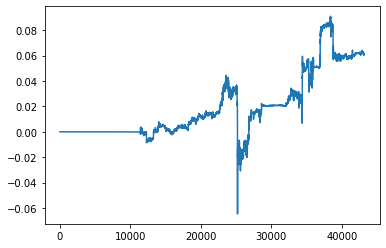

In [21]:
plt.plot(test.cumsum()+fee_cumsum)
plt.show()

In [22]:
df['btcusdt_FUTURES_adjusted'] = df['btcusdt_FUTURES_ret'][1:] - np.mean(df['btcusdt_FUTURES_ret'][1:])

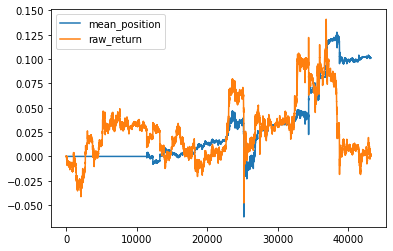

In [23]:
test = df['btcusdt_FUTURES_adjusted']*mean_position
plt.plot(test.cumsum(), label="mean_position")
plt.plot(df['btcusdt_FUTURES_adjusted'][1:].cumsum(), label="raw_return")
plt.legend()
plt.show()

In [24]:
clip_signal = mean_position[1:]
test_period = df['btcusdt_FUTURES_adjusted'][1:]
detrended_reward = test_period-np.mean(test_period)

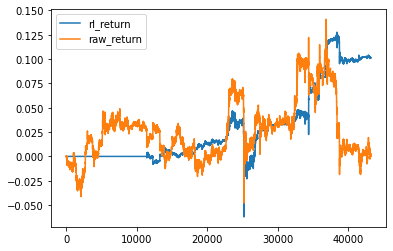

In [25]:
plt.plot((clip_signal*detrended_reward).cumsum(), label="rl_return")
plt.plot(detrended_reward.cumsum(), label="raw_return")
plt.legend()
plt.show()

Bootstrap
- 중심극한정리
- 리샘플의 평균 -> 평균의 리샘플
- rule return from detrended return
- rule return centering
- (if the rule was able to earn a non-zero return on detrended data, its returns must be zero centered)

In [26]:
rule_return = clip_signal * detrended_reward
target = np.mean(rule_return)

In [27]:
bootstrap = []
bootstrap_return = rule_return - target
for i in tqdm(range(100000)):
    _ = np.random.choice(bootstrap_return, size = len(bootstrap_return), replace=True)
    bootstrap.append(np.mean(_))

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:28<00:00, 1131.05it/s]


(-1e-05, 1e-05)

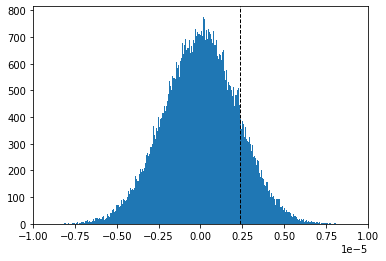

In [28]:
plt.hist(bootstrap,bins=100)
plt.axvline(target, color='k', linestyle='dashed', linewidth=1)
plt.xlim([-1e-5, 1e-5])

In [29]:
1-(np.count_nonzero(np.array(bootstrap)<target) / np.array(bootstrap).size)

0.14566999999999997

Monte-Carlo
- 무작위로 생성된 time series에 비해서 얼마나 더 나은가
- This is accomplished by randomly pairing or permuting the detrended daily returns of the market with the ordered times series representing the sequence of daily rule output values
- noise rule(random rule)과 tested rule이 얼마나 다른지 비교

In [30]:
monte = []
for i in tqdm(range(100000)):
    _ = np.random.permutation(detrended_reward)
    monte.append(np.mean(_*clip_signal))

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [01:50<00:00, 903.16it/s]


(-1e-05, 1e-05)

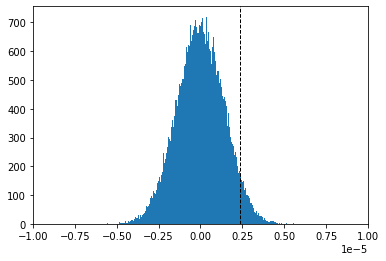

In [31]:
plt.hist(monte,bins=100)
plt.axvline(target, color='k', linestyle='dashed', linewidth=1)
plt.xlim([-1e-5, 1e-5])

In [32]:
1-(np.count_nonzero(np.array(monte)<target) / np.array(monte).size)

0.04964000000000002